In [14]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'../')

# Export cells
!python notebook2script.py blood_vessel_pipeline.ipynb -out-folder=../pyvesto

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Converted processor.py to ../pyvesto/processor.py


In [32]:
# Pipeline
#export processor.py
from pyvesto import file_util, img_io, segmentation, skeleton, util, measure
from pyvesto.graph.creation import create_graph
import pyvesto.graph.adjustment as net_adjust
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import os
import pickle
import tifffile

class Processor:
    
    def __init__(self, batch_name, in_folder, out_folder, out_folder_res, result_format, name_filter, run_steps, save_steps, 
                 step_directories, channel_to_use, threshold, sigma, radius, comp_size, length_threshold, 
                 tortuosity_scale, roi, start_at, num_threads, verbosity):
        """Class for segmenting, representing and characterizing 2D or 3D blood vessel images. The 
        methods contained here are very specific to some analyses done by Prof. Cesar Comin. They should 
        be adapted to process blood vessel images for other experiments.

        Parameters
        ----------  
        batch_name : str
            Name of the batch
        in_folder : Path or str
            Folder containing input images
        out_folder : Path or str
            Folder to save images generated from intermediate steps
        out_folder_res : Path or str
             Folder to save the results
        result_format : {'dict', 'table', 'disk'}
            How to save the results. If 'disk', a csv file is saved on the disk.
        name_filter : func
            Function for filtering the files. Returns True if the file should be processd and False otherwise.
        run_steps : dict
            Dictionary containing the processing steps to run. Has the form {'segmentation':{True,False}, 
            'skeletonization':{True,False}, 'network':{True,False}, 'analysis':{True,False}}
        save_steps : dict
            Dictionary containing which intermediary data should be saved on disk. Has the form
            {'segmentation':{True,False}, 'skeletonization':{True,False}, 'network-original':{True,False},
             'network-simple':{True,False}, 'network-final':{True,False}}
        step_directories : dict
            Directory names to save intermediary data. Has the form {'segmentation':'folder_name', 
            'skeletonization':'folder_name', 'network-original':'folder_name', 
            'network-simple':'folder_name', 'network-final':'folder_name'}
        channel_to_use : int
            Image channel to use when reading files.
        threshold : str
            Name of the file containing thresholds for segmentation. Can also be a float, in which case
            the value is used for all images.
        sigma : tuple of float
            Standard deviation of the Gaussian used for smoothing the image before segmentation
        radius : int
            Radius used for adaptive thresholding.
        comp_size : int
            Connected components smaller than `comp_size` will be removed after segmenting the image.
        length_threshold : float
            Threshold for removing small blood vessel branches.
        tortuosity_scale : float
            Scale used for calculating the tortuosity.
        start_at : int, optional
            Given the list of images to process, start at this index. If 0 or None, all images are processed.
        roi : tuple of slice, optional
            If not None, crop image before processing using the slices provided.
        num_threads : int
            Number of threads to use for skeleton calculation
        verbosity : {0, 1, 2, 3}
            Level of verbosity. 
        storage : dict
            Dictionary for storing the calculated graphs and morphometry.
        """
        
        self.batch_name = batch_name                 
        self.in_folder = Path(in_folder)             
        self.out_folder = Path(out_folder)           
        self.out_folder_res = Path(out_folder_res)   
        self.result_format = result_format           
        self.name_filter = name_filter
        self.run_steps = run_steps
        self.save_steps = save_steps
        self.step_directories = step_directories
        self.channel_to_use = channel_to_use
        self.threshold = threshold
        self.sigma = sigma
        self.radius = radius
        self.comp_size = comp_size
        self.length_threshold = length_threshold
        self.tortuosity_scale = tortuosity_scale
        self.start_at = start_at
        self.roi = roi
        self.num_threads = num_threads
        self.verbosity = verbosity
        self.storage = {}
        
    def run(self):
        """Start processing the images."""
        
        results = None
        run_steps = self.run_steps
        
        if run_steps['segmentation'] or run_steps['skeletonization'] or run_steps['network']:
            self.imgs_to_graphs(self.batch_name, self.in_folder, self.out_folder, self.name_filter, self.run_steps, 
                                self.save_steps, self.step_directories, self.channel_to_use, self.threshold,
                                self.sigma, self.radius, self.comp_size, self.length_threshold, self.roi, self.start_at,
                                self.num_threads, self.verbosity)

        if run_steps['analysis']:
            in_folder_res = Path(self.out_folder)/'network/final'
            name_filter = lambda file: ('.' not in file) or ('pickle' in file)
            results = self.analyze_graphs(self.batch_name, in_folder_res, self.out_folder_res, 
                                          self.tortuosity_scale, self.result_format, name_filter, self.verbosity)

        return results

    def img_to_graph(self, file, in_folder, out_folder, run_steps, save_steps, step_directories, channel_to_use, threshold, 
                     sigma, radius, comp_size, length_threshold, roi, num_threads, verbosity):
        """Convert a 2D or 3D blood vessel image into a graph."""

        filename = file.stem
        img = self.read_and_prepare_img(file, channel_to_use, roi)
        if save_steps['original']:
            img_proj = np.max(img.data, 0) if img.data.ndim==3 else img.data
            self.save_object_proj(file.parent, filename, img, False, img_proj)

        if run_steps['segmentation']:
            if verbosity>=2:
                print('Segmenting...')
            img_bin = segmentation.vessel_segmentation(img, threshold, sigma=sigma, radius=radius, comp_size=comp_size)
            if save_steps['segmentation']:
                out_sample_folder = self.gen_out_sample_folder(in_folder, out_folder, file, step_directories['segmentation'])
                img_bin_proj = np.sum(img_bin.data, 0) if img_bin.data.ndim==3 else img_bin.data
                self.save_object_proj(out_sample_folder, filename, img_bin, True, img_bin_proj, 'jet')

        if run_steps['skeletonization']:
            if verbosity>=2:
                print('Creating skeleton...')
            img_skel = skeleton.skeletonize(img_bin, num_threads=num_threads, verbosity=verbosity)
            if save_steps['skeletonization']:
                out_sample_folder = self.gen_out_sample_folder(in_folder, out_folder, file, step_directories['skeletonization'])
                img_skel_proj = np.max(img_skel.data, 0) if img_skel.data.ndim==3 else img_skel.data
                self.save_object_proj(out_sample_folder, filename, img_skel, True, img_skel_proj)

        if run_steps['network']:
            if verbosity>=2:
                print('Creating graph...')
                
            graph = create_graph(img_skel, verbose=(verbosity>=3))
            graph_simple = net_adjust.simplify(graph, False, verbose=(verbosity>=3))
            graph_final = net_adjust.adjust_graph(graph_simple, length_threshold, False, True, verbose=(verbosity>=3))

            if save_steps['network-original']:
                out_sample_folder = self.gen_out_sample_folder(in_folder, out_folder, file, step_directories['network-original'])
                self.save_graph(out_sample_folder, filename, graph, True)

            if save_steps['network-simple']:
                out_sample_folder = self.gen_out_sample_folder(in_folder, out_folder, file, step_directories['network-simple'])
                self.save_graph(out_sample_folder, filename, graph_simple, True)

            if save_steps['network-final']:
                out_sample_folder = self.gen_out_sample_folder(in_folder, out_folder, file, step_directories['network-final'])
                self.save_graph(out_sample_folder, filename, graph_final, True)
                
                self.storage['graph_final'] = graph_final

        return graph_final
        
    def imgs_to_graphs(self, batch_name, in_folder, out_folder, name_filter, run_steps, save_steps, step_directories,
                      channel_to_use, threshold, sigma, radius, comp_size, length_threshold, roi, start_at,
                      num_threads, verbosity):
        """Convert a set of 2D or 3D blood vessel images into graphs."""

        out_folder = Path(out_folder)
        files = self.prepare_files(in_folder, batch_name, out_folder, save_steps, step_directories, name_filter)
        num_files = len(files)
        if (start_at is None) or (start_at==0):
            first_index = 0
        else:
            first_index = None
            for idx, file in enumerate(files):
                if start_at in str(file):
                    first_index = idx
                    break
            if first_index is None:
                print('Warning, tried to start at file {} but the file was not found. Starting from the beginning')
                first_index = 0
            files = files[first_index:]
            
        #import pdb; pdb.set_trace()
        if isinstance(threshold, str):
            threshold_dict = self.load_thresholds(threshold)

        for idx, file in enumerate(files):

            filename = file.stem
            if verbosity:
                print(f'Processing file {filename} ({first_index+idx+1} of {num_files})...')

            if isinstance(threshold, str):
                file_tag = self.get_file_tag(file)
                threshold = threshold_dict[file_tag]
            self.img_to_graph(file, in_folder, out_folder, run_steps, save_steps, 
                              step_directories, channel_to_use, threshold, sigma, radius, 
                              comp_size, length_threshold, roi, num_threads, verbosity)
            
    def analyze_graph(self, file, tortuosity_scale):
        """Calculate the length, number of branching points and tortuosity of a blood vessel graph."""

        img_roi = None
        graph_final = pickle.load(open(file, 'rb'))
        length = measure.vessel_density(graph_final, graph_final.graph['shape'], img_roi=img_roi, scale_factor=1e-3)
        num_branches = measure.branch_point_density(graph_final, graph_final.graph['shape'], img_roi=img_roi, 
                                                    scale_factor=1e-3)
        tortuosity = measure.tortuosity(graph_final, tortuosity_scale, True)

        return length, num_branches, tortuosity

    def analyze_graphs(self, batch_name, in_folder_res, out_folder_res, tortuosity_scale, result_format, 
                       name_filter, verbosity):
        """Calculate the length, number of branching points and tortuosity of a set of
        blood vessel graphs."""

        in_folder_batch = Path(in_folder_res)/batch_name
        root = Path(in_folder_batch)
        _, files_net = file_util.get_files(root, name_filter)
        
        if verbosity:
            num_files = len(files_net)
            print('Calculating properties...')

        results = {}
        for idx, file in enumerate(files_net):
            
            filename = file.stem
            if verbosity:
                print(f'Processing file {filename} ({idx+1} of {num_files})...', end='\r')

            length, num_branches, tortuosity = self.analyze_graph(file, tortuosity_scale)
            results[filename] = {'length':length, 'num_branches':num_branches, 'tortuosity':tortuosity}
        print('')
            
        self.storage['results'] = results
        
        if result_format=='dict':
            pass
        elif result_format=='table' or result_format=='disk':   
            results = self.generate_table(results)
            if result_format=='disk':
                if not out_folder_res.is_dir():
                    os.mkdir(out_folder_res)
                open(f'{out_folder_res/batch_name}.tsv', 'w').write(results)
                
        if verbosity:
            print('Done!')
        
        return results
    
    def generate_table(self, results):
        """Generate nice table containing blood vessel morphometry."""
        
        header = "Name\tLength (mm/mm^3)\tBranching points (1/mm^3)\tTortuosity"
        
        table_str = header+'\n'
        for filename in results:
            graph_meas = results[filename]
            length, num_branches, tortuosity = graph_meas['length'], graph_meas['num_branches'], graph_meas['tortuosity']
            line_str = f'{filename}\t{length}\t{num_branches}\t{tortuosity}\n'
            table_str += line_str
        
        return table_str
    
    def prepare_files(self, in_folder, batch_name, out_folder, save_steps, step_directories, name_filter):
        """Obtain list of files for processing and generate necessary folders for saving intermediary
        steps of the pipeline (segmented blood vessels, skeleton, etc)."""

        # Read file list and make output folders
        in_folder_batch = Path(in_folder)/batch_name
        root = Path(in_folder_batch)
        file_tree, files = file_util.get_files(root, name_filter)
        step_dirs = [step_directories[step] for step, save in save_steps.items() if save]
        file_util.make_directories(file_tree, out_folder, step_dirs, ['maximum_projection', 'pickle'])

        return files

    def gen_out_sample_folder(self, in_folder, out_folder, file, step):
        """Generate a new folder path."""

        file_rel_path = file.relative_to(in_folder)
        return (out_folder/step/file_rel_path).parent

    def read_and_prepare_img(self, file, channel=0, roi=None):
        """Read image form disk, transform its data to float, apply the linear transformation 
        [min, max]->[0, 255] and interpolate the image to make it isotropic."""

        img = img_io.read_img(file, channel=channel)
        if roi is not None:
            img.data = img.data[roi]
            img.shape = img.data.shape
        img_dtype = img.data.dtype
        if img_dtype!=np.uint16 and img_dtype!=np.uint8:
            raise ValueError(f'Pixel data type is {img_dtype}, but should be either uint8 or uint16.')
        img.to_float()
        img.stretch_data_range(255)
        img.make_isotropic()

        return img

    def save_object_proj(self, directory, name, obj, save_obj=True, obj_proj=None, cmap=None):
        """Save an object as a pickle file. Optionally, also save an image representing the object. 
        This is useful for saving a 3D image together with a 2D projection or a graph and its
        respective image."""

        if cmap is None:
            cmap = 'gray'

        directory = Path(directory)

        if save_obj:
            out_pickle_dir = directory/'pickle'
            if not out_pickle_dir.is_dir():
                os.mkdir(out_pickle_dir)
            pickle.dump(obj, open(out_pickle_dir/(name+'.pickle'), 'wb'))

        if obj_proj is not None:
            out_proj_dir = directory/'maximum_projection'
            if not out_proj_dir.is_dir():
                os.mkdir(out_proj_dir)
            plt.imsave(out_proj_dir/(name+'.png'), obj_proj, cmap=cmap)

    def save_graph(self, directory, name, graph, save_graph=True, cmap=None, node_pixels_color=(0, 0, 0)):
        """Save a graph to disk."""

        directory = Path(directory)

        img_graph = util.graph_to_img(graph, node_color=(255, 255, 255), node_pixels_color=node_pixels_color, 
                                      edge_color=(255, 255, 255))
        img_graph_proj = np.max(img_graph, 0) if img_graph.ndim==4 else img_graph   # Graph image has color
        self.save_object_proj(directory, name, graph, save_obj=save_graph, obj_proj=img_graph_proj, cmap=cmap)

    def load_thresholds(self, filename):
        """Load file containing the thresholds for blood vessel segmentation."""
        
        data = open(filename, 'r').readlines()

        threshold_dict = {}
        in_batch = False
        for line_index, line in enumerate(data):
            if line[0]=='#':
                in_batch = False
                batch_name = line[1:].strip()
                if batch_name==self.batch_name:
                    in_batch = True
            elif in_batch:
                splitted_line = line.strip().split('\t')
                index, stack_name, best_threshold = splitted_line
                threshold_dict[stack_name] = float(best_threshold)

        return threshold_dict

    def try_thresholds(self, threshold_values, out_folder):

        batch_name = self.batch_name
        in_folder = self.in_folder
        name_filter = self.name_filter
        out_folder = Path(out_folder)/batch_name

        in_folder_batch = Path(in_folder)/batch_name
        root = Path(in_folder_batch)
        file_tree, files = file_util.get_files(root, name_filter)
        num_files = len(files)
        
        for idx, file in enumerate(files):

            filename = file.stem
            if self.verbosity:
                print(f'Processing file {filename} ({idx+1} of {num_files})...')

            img = self.read_and_prepare_img(file, self.channel_to_use)
            
            for threshold in threshold_values:
                img_bin = segmentation.vessel_segmentation(img, threshold, sigma=self.sigma, radius=self.radius,
                                                comp_size=self.comp_size)
                img_bin_all_comps = segmentation.vessel_segmentation(img, threshold, sigma=self.sigma, radius=self.radius,
                                                comp_size=0)

                img_bin_np = img_bin.data
                img_diff = np.logical_xor(img_bin_np, img_bin_all_comps.data)
                img_final_diff = img_bin_np.astype(np.uint8)*2
                img_final_diff[img_diff] = 1		

                if not out_folder.is_dir():
                    os.mkdir(out_folder)
                if img_final_diff.ndim==3:
                    img_out_proj = np.max(img_final_diff, axis=0)
                else:
                    img_proj_out = img_final_diff
                file_tag = self.get_file_tag(file)
                plt.imsave(out_folder/f'{file_tag}_{threshold:.1f}.png', img_proj_out, cmap='hot')

    def print_batch_files(self, only_files=True, replace_slash=None):

        if replace_slash is None:
            replace_slash = '/'

        in_folder_batch = Path(self.in_folder)/self.batch_name
        root = Path(in_folder_batch)
        file_tree, files = file_util.get_files(root, self.name_filter)   
        for file in files:
            if only_files:
                name_to_print = file.stem
            else:
                name_to_print = self.get_file_tag(file, sep=replace_slash)
            print(name_to_print)

    def get_file_tag(self, file, sep='@'):

            file_parts = file.parts
            ind = file_parts.index(self.batch_name)
            tag = sep.join(file_parts[ind+1:-1])
            tag += '@'+file.stem

            return tag

    def verify_results(self, out_file):

        in_folder_batch = Path(self.in_folder)/self.batch_name
        root = Path(in_folder_batch)
        file_tree, files = file_util.get_files(root, self.name_filter)
        out_folder = Path(self.out_folder)
        num_files = 2*len(files)

        
        for idx, file in enumerate(files):
            filename = file.stem
            img = self.read_and_prepare_img(file, self.channel_to_use, self.roi)

            out_sample_folder = self.gen_out_sample_folder(self.in_folder, out_folder, file, self.step_directories['network-final'])
            out_sample_folder = out_sample_folder/'pickle'/f'{filename}.pickle'
            graph = pickle.load(open(out_sample_folder, 'rb'))
            img_graph = util.graph_to_img(graph, node_color=(255, 255, 255), node_pixels_color=(0, 0, 0), 
                                      edge_color=(255, 255, 255))
            img_graph = img_graph[:,:,0]

            if img.ndim>=3:
                img_proj = np.max(img.data, axis=0)
            else:
                img_proj = img.data

            if idx==0:
                verification_stack = np.zeros((num_files, img_proj.shape[0], img_proj.shape[1]), dtype=np.uint8)
            
            verification_stack[2*idx] = np.round(img.data).astype(int)
            verification_stack[2*idx+1] = img_graph


        tifffile.imsave(out_file, verification_stack) 

In [33]:
params = {
    # Pipeline params
    'run_steps':     {'segmentation':True, 'skeletonization':True, 'network':True, 'analysis':True},
    'save_steps':    {'original': True, 'segmentation':True, 'skeletonization':True, 'network-original':True,
                      'network-simple':True, 'network-final':True},    # Save results from these steps
    'roi': None,  #(slice(None), slice(500, 600), slice(500, 600)),
    'num_threads': 10,
    'verbosity': 2,
    # File params
    'batch_name':    '3D_Vessels_HMGB1_P14',
    'in_folder':     '/home/cesar/Dropbox/ufscar/Baptiste-Development/data/Original/', #'data/original/',
    'out_folder':    '../data',
    'name_filter': lambda x: x not in ['maximum_projection', 'maximum_projection_old'],   # Do not read images inside these folders
    'step_directories': {'segmentation':'binary', 'skeletonization':'skeleton', 'network-original':'network/original',
                        'network-simple':'network/simple', 'network-final':'network/final'},
    'channel_to_use': None,
    'start_at': None,
    # Segmentation params
    'threshold': '/home/cesar/Dropbox/ufscar/Baptiste-Development/data/thresholds.txt',
    'sigma': [0.1, 1., 1.],
    'radius': 40,
    'comp_size': 500,
    # Graph params
    'length_threshold': 10,
    # Measurement params
    'tortuosity_scale': 40,
    'out_folder_res': '../data/results',
    'result_format': 'disk',
}

processor = Processor(**params)
results = processor.run()

Calculating properties...

Done!ssing file M26-P14-PC-C (108 of 108)...


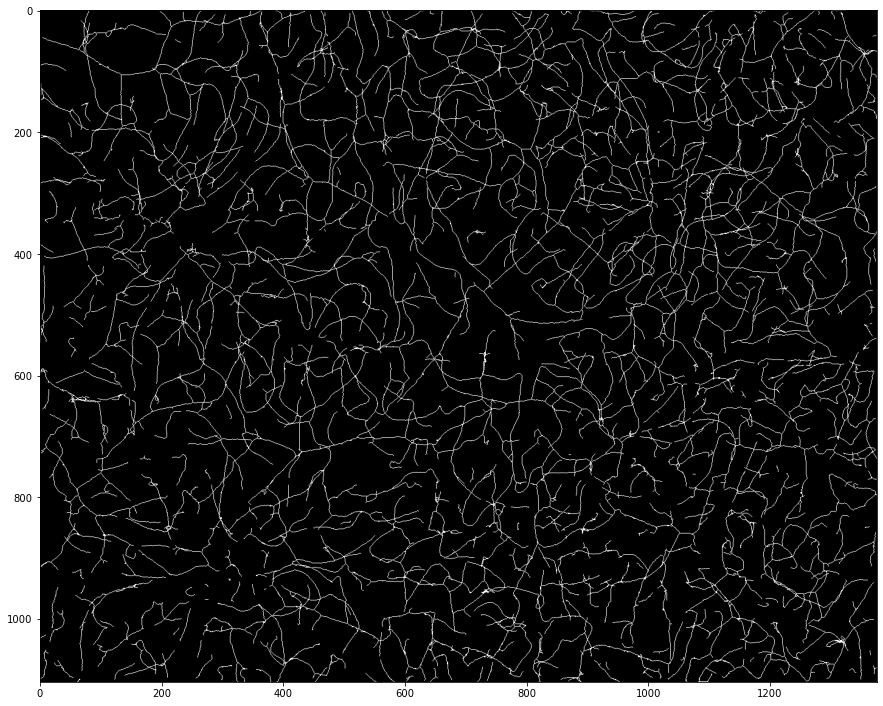

In [5]:
from pyvesto.image import Image
import matplotlib.pyplot as plt

#img_skel = img_io.read_img('../data/original/tests/M12-P14-AC-A_skel.tiff', read_pix_size=False)
#img_skel.change_type_range(curr_max=255, new_max=1)
#img_skel.to_uint8()
file = Path('data/skeleton/3D_Vessels_HMGB1_P14/pickle/M14-P14-AC-B.pickle')
img_skel = pickle.load(open(file, 'rb'))
img_skel.to_uint8()
#img_skel = Image(img_skel, '.', pix_size=(1., 1., 1.))
img_skel
plt.figure(figsize=[15,15])
plt.imshow(np.max(img_skel.data, axis=0), 'gray')

In [23]:
in_folder = Path(params['in_folder'])
out_folder = Path(params['out_folder'])
length_threshold = params['length_threshold']
step_directories = params['step_directories']
filename = file.stem

graph = create_graph(img_skel, False)
graph_simple = net_adjust.simplify(graph, True, False)
graph_final = net_adjust.adjust_graph(graph_simple, length_threshold, False, True, False)

"""if params['save_steps']['network-original']:
    out_sample_folder = gen_out_sample_folder(in_folder, out_folder, file, step_directories['network-original'])
    save_graph(out_sample_folder, filename, graph, True, node_pixels_color=(255, 255, 255))

if save_steps['save_steps']['network-simple']:
    out_sample_folder = gen_out_sample_folder(in_folder, out_folder, file, step_directories['network-simple'])
    save_graph(out_sample_folder, filename, graph_simple, True)

if save_steps['save_steps']['network-final']:
    out_sample_folder = gen_out_sample_folder(in_folder, out_folder, file, step_directories['network-final'])
    save_graph(out_sample_folder, filename, graph_final, True)""";

In [192]:
from pyvesto import measure

in_folder_res = Path(out_folder)/'network/final'
out_folder_res = '../data/results'
tortuosity_scale = 40

in_folder_batch = Path(in_folder_res)/batch_name
root = Path(in_folder_batch)
_, files_net = file_util.get_files(root, name_filter)

for idx, file in enumerate(files_net[:1]):

    graph_final = pickle.load(open(file, 'rb'))
    length = measure.vessel_density(graph_final, graph_final.graph['shape'], scale_factor=1e-3)
    num_branches = measure.branch_point_density(graph_final, graph_final.graph['shape'], scale_factor=1e-3)
    tortuosity = measure.tortuosity(graph_final, tortuosity_scale, True)
    print(length)
    print(num_branches)
    print(tortuosity)

1304.4959098975264
14634.666583126243
1.8772264346485867


In [34]:
data = open('/media/cesar/Dropbox/Dropbox/ufscar/pyvesto/data/results/3D_Vessels_HMGB1_P14.tsv').read().splitlines()
meas = np.zeros((len(data)-1, 3))
for idx, line in enumerate(data[1:]):
    _, *meas[idx] = line.split('\t')
    
data_old = open('/media/cesar/Dropbox/Dropbox/ufscar/pyvesto/data/results/3D_Vessels_HMGB1_P14_old.tsv').read().splitlines()
meas_old = np.zeros((len(data_old)-1, 3))
for idx, line in enumerate(data_old[1:]):
    _, *meas_old[idx] = line.split('\t')

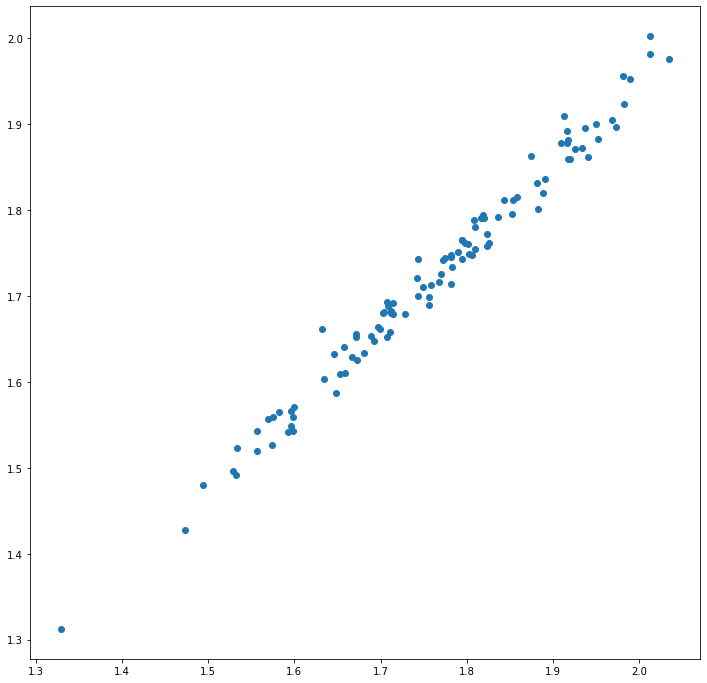

In [42]:
plt.figure(figsize=[12,12])
plt.plot(meas_old[:,2], meas[:,2], 'o')

In [43]:
np.max(np.abs(meas_old[:,2] - meas[:,2])/meas_old[:,2])

0.04320328612838051

In [39]:
import scipy

scipy.polyfit(meas_old[:,0], meas[:,0], 1)

/home/cesar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.polyfit is deprecated and will be removed in SciPy 2.0.0, use numpy.polyfit instead
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 0.96517213, 16.28270719])

In [31]:
processor = Processor(**params)

out_folder = Path(params['out_folder'])
in_folder = '/home/cesar/Dropbox/ufscar/Baptiste-Development/data/Original/'
batch_name = params['batch_name']
name_filter = params['name_filter']
length_threshold = params['length_threshold']
step_directories = params['step_directories']
verbosity = 1

in_folder_batch = Path(in_folder)/batch_name
root = Path(in_folder_batch)
file_tree, files = file_util.get_files(root, name_filter)
num_files = len(files)

for idx, file in enumerate(files):

    filename = file.stem
    if verbosity:
        print(f'\nProcessing file {filename} ({idx+1} of {num_files})...')

    #graph = create_graph(img_skel, verbose=verbosity)
    file_net_original = f'../data/network/original/{batch_name}/pickle/{filename}.pickle'
    graph = np.load(file_net_original, allow_pickle=True)
    graph_simple = net_adjust.simplify(graph, False)
    graph_final = net_adjust.adjust_graph(graph_simple, length_threshold, False, True)

    out_sample_folder = processor.gen_out_sample_folder(in_folder, out_folder, file, step_directories['network-simple'])
    processor.save_graph(out_sample_folder, filename, graph_simple, True)

    out_sample_folder = processor.gen_out_sample_folder(in_folder, out_folder, file, step_directories['network-final'])
    processor.save_graph(out_sample_folder, filename, graph_final, True)



Processing file M12-P14-AC-A (1 of 108)...

Processing file M12-P14-AC-B (2 of 108)...

Processing file M12-P14-AC-C (3 of 108)...

Processing file M12-P14-OC-A (4 of 108)...

Processing file M12-P14-OC-B (5 of 108)...

Processing file M12-P14-OC-C (6 of 108)...

Processing file M12-P14-PC-A (7 of 108)...

Processing file M12-P14-PC-B (8 of 108)...

Processing file M12-P14-PC-C (9 of 108)...

Processing file M13-P14-AC-A (10 of 108)...

Processing file M13-P14-AC-B (11 of 108)...

Processing file M13-P14-AC-C (12 of 108)...

Processing file M13-P14-OC-A (13 of 108)...

Processing file M13-P14-OC-B (14 of 108)...

Processing file M13-P14-OC-C (15 of 108)...

Processing file M13-P14-PC-A (16 of 108)...

Processing file M13-P14-PC-B (17 of 108)...

Processing file M13-P14-PC-C (18 of 108)...

Processing file M14-P14-AC-A (19 of 108)...

Processing file M14-P14-AC-B (20 of 108)...

Processing file M14-P14-AC-C (21 of 108)...

Processing file M14-P14-OC-A (22 of 108)...

Processing file M1

In [29]:
out_sample_folder

PosixPath('../data/network/final/3D_Vessels_HMGB1_P14')

In [71]:
# Apaga_bif old

import numpy as np
import scipy.ndimage as ndi
import util

def Get_eid(g,ed):	

    edges = np.array(g.get_edgelist())
    no1,no2 = g.es[ed].tuple

    ind = np.nonzero((no1==edges[:,0])&(no2==edges[:,1]))[0]
    ind = ind.tolist()

    return ind		

def Flood_fill(res,grand_z,grand_x,grand_y):

    bif_nodes = []
    prox_bif = []
    tips = []

    bif_nodes.append([grand_z,grand_x,grand_y])
    prox_bif.append([grand_z,grand_x,grand_y])
    res[grand_z,grand_x,grand_y] = -1

    while (len(prox_bif)>0):
        z,x,y = prox_bif.pop()
        list_viz = vizinhos(res,[z,x,y])
        for viz in list_viz:
            z_viz,x_viz,y_viz = viz

            if (res[z_viz,x_viz,y_viz]==0):			# Isolated pixels in the image
                res[z_viz,x_viz,y_viz] = -1

            if (res[z_viz,x_viz,y_viz]==1):			# Disconsider tips connected to bifurcations
                #bif_nodes.append([z_viz,x_viz,y_viz])
                res[z_viz,x_viz,y_viz] = -1	

            elif (res[z_viz,x_viz,y_viz]==2):
                tips.append([z_viz,x_viz,y_viz])

            elif (res[z_viz,x_viz,y_viz]>=3):
                prox_bif.append([z_viz,x_viz,y_viz])
                bif_nodes.append([z_viz,x_viz,y_viz])
                res[z_viz,x_viz,y_viz] = -1

    return [bif_nodes,tips]

def vizinhos(res,point):

    z,x,y = point

    ind = []

    for k in range(z-1,z+2):
        for i in range(x-1,x+2):
            for j in range(y-1,y+2):			
                if (res[k,i,j]>=0):
                    ind.append([k,i,j])


    return ind	

def Elimina(img,img_lab,tam_comp,tam=20):

    ind = np.nonzero(tam_comp<=tam)[0]+1

    if (ind.size < tam_comp.size/2):

        img_f = img.copy()

        for i in range(0,ind.size):

            comp = ind[i]
            ind2 = np.nonzero(img_lab==comp)
            img_f[ind2] = 0


    else:
        ind = np.nonzero(tam_comp>tam)[0]+1

        img_f = np.zeros_like(img)

        for i in range(0,ind.size):

            comp = ind[i]
            ind2 = np.nonzero(img_lab==comp)
            img_f[ind2] = 1

    return img_f

def Cria_rede(img):

    size_z,size_x,size_y = img.shape

    size_z += 2
    size_x += 2
    size_y += 2

    img_pad = np.zeros([size_z,size_x,size_y])		# pad com zeros
    img_pad[1:-1,1:-1,1:-1] = img
    img = img_pad

    s = np.ones([3,3,3])


    img_lab,num_comp = ndi.label(img,s)
    tam_comp = ndi.sum(img, labels=img_lab, index=range(1,num_comp+1))
    img = Elimina(img,img_lab,tam_comp,2)								# Disconsider isolated pixels and connected tips


    # res armazena o numero de vizinhos que cada pixel possui, pixel de fundo possui valor -1
    res = ndi.correlate(img, s, output=None, mode='constant', cval=0., origin=0)
    res = res*img - 1
    res_aux = res.copy()

    img_label,num_comp = ndi.label((res>=3) | (res==1),s)
    img_label -= 1


    ind_at = 0		# Indice do proximo no a ser adicionado na rede

    g = Graph()		
    node_att = []

    # Find bifurcations
    for grand_z in range(size_z):
        for grand_x in range(size_x):
            for grand_y in range(size_y):

                if (res[grand_z,grand_x,grand_y]==1):

                    res[grand_z,grand_x,grand_y] = -1
                    viz = vizinhos(res,[grand_z,grand_x,grand_y])[0]
                    if (res[viz[0],viz[1],viz[2]]==2):								
                        g.add_vertex()
                        node_att.append([[[grand_z,grand_x,grand_y]],[viz]])
                    elif (res[viz[0],viz[1],viz[2]]>=3):	
                        node = Flood_fill(res,viz[0],viz[1],viz[2])
                        g.add_vertex()
                        node_att.append(node)

                if (res[grand_z,grand_x,grand_y]>=3):

                    node = Flood_fill(res,grand_z,grand_x,grand_y)

                    g.add_vertex()
                    node_att.append(node)

    ed_att = []
    for node in range(g.vcount()):
        
        tips = node_att[node][1]
        for j in range(len(tips)):
            prox_point = tips[j]

            if (res[prox_point[0],prox_point[1],prox_point[2]]!=-1):		# Verify if edge is already in the network

                ed_points = []
                prox_point = [prox_point]
                while (len(prox_point)>0):

                    prox_point = prox_point[0]
                    ed_points.append(prox_point)
                    res[prox_point[0],prox_point[1],prox_point[2]] = -1
                    prox_point = vizinhos(res,prox_point)

                viz = vizinhos(img_label,ed_points[-1])

                if (len(viz)==1):
                    viz_ind = img_label[viz[0][0],viz[0][1],viz[0][2]]
                    g.add_edge(int(node),int(viz_ind))
                    ed_att.append(ed_points)
                else:									# Treat the case where a segment has size equal to one pixel
                    viz_ind = img_label[viz[0][0],viz[0][1],viz[0][2]]
                    if (viz_ind!=node):	
                        g.add_edge(int(node),int(viz_ind))
                        ed_att.append(ed_points)
                    else:
                        viz_ind = img_label[viz[1][0],viz[1][1],viz[1][2]]
                        if (viz_ind!=node):
                            g.add_edge(int(node),int(viz_ind))
                            ed_att.append(ed_points)



    node_pos = []								# Correct positions for unpadded image
    for node in node_att:
        points = np.array(node[0])-1
        node_pos.append(points.tolist())

    ed_pos = []
    for edge in ed_att:
        points = np.array(edge)-1
        ed_pos.append(points.tolist())

    g.vs.set_attribute_values('pixels',node_pos)
    g.es.set_attribute_values('path',ed_pos)

    degree = np.array(g.degree())
    ind = np.nonzero(degree==0)[0]
    g.delete_vertices(ind.tolist())				# Disconsider isolated bifurcations

    return g

def Simplify(g):


    grau = np.array(g.degree())
    vet_pos_no = g.vs.get_attribute_values('pixels')
    vet_pos_ed = g.es.get_attribute_values('path')

    for no in range(g.vcount()):

        pos_no = vet_pos_no[no]

        if (len(pos_no)>1):
            m_pos_no = np.round(np.mean(pos_no,axis=0)).astype(np.int)

            viz = g.neighbors(no)

            for k in range(grau[no]):
                eid = g.get_eid(no,viz[k])

                n_rep = g.count_multiple(eid)

                if (n_rep>1):
                    list_ed = Get_eid(g,eid)
                else:
                    list_ed = [eid]

                #for r in range(eid-n_rep+1,eid+1):
                #	list_ed.append(r)

                for eid in list_ed:
                    e1np = np.array(vet_pos_ed[eid][:])

                    if (g.is_loop(eid)==False):


                        # Make edges run in the same direction (if we travel along both edges, we go from [0] to [-1] in edge 1
                        # and then from [0] to [-1] in edge 2)
                        dist = [np.sqrt(np.sum((m_pos_no-e1np[0])**2.)),np.sqrt(np.sum((m_pos_no-e1np[-1])**2.))]
                        if (dist[0]>dist[1]):
                            e1np = e1np[::-1]

                        vet = e1np[0]-m_pos_no
                        t = np.linspace(0,1,1000)
                        seg = m_pos_no + vet*np.array([t]).T
                        seg = np.round(seg).astype(np.int)

                        new_seg = [seg[0]]
                        for j in range(1,len(seg)):
                            #if ((seg[j][0] != seg[j-1][0]) | (seg[j][1] != seg[j-1][1]) | (seg[j][2] != seg[j-1][2])):
                            if tuple(seg[j])!=tuple(seg[j-1]):
                                new_seg.append(seg[j])

                        new_seg.pop(0)
                        if (len(new_seg)>0):
                            new_seg.pop(-1)

                        if (len(new_seg)>0):
                            new_edge = np.concatenate((np.array(new_seg),e1np))
                        else:
                            new_edge = e1np.copy()

                        vet_pos_ed[eid] = new_edge.tolist()

                    else:

                        vet = e1np[0]-m_pos_no
                        t = np.linspace(0,1,1000)
                        seg = m_pos_no + vet*np.array([t]).T
                        seg = np.round(seg).astype(np.int)

                        new_seg1 = [seg[0]]
                        for j in range(1,len(seg)):
                            #if ((seg[j][0] != seg[j-1][0]) | (seg[j][1] != seg[j-1][1]) | (seg[j][2] != seg[j-1][2])):
                            if tuple(seg[j])!=tuple(seg[j-1]):
                                new_seg1.append(seg[j])

                        new_seg1.pop(0)
                        if (len(new_seg1)>0):
                            new_seg1.pop(-1)

                        vet = e1np[-1]-m_pos_no
                        t = np.linspace(0,1,1000)
                        seg = m_pos_no + vet*np.array([t]).T
                        seg = np.round(seg).astype(np.int)

                        new_seg2 = [seg[0]]
                        for j in range(1,len(seg)):
                            #if ((seg[j][0] != seg[j-1][0]) | (seg[j][1] != seg[j-1][1]) | (seg[j][2] != seg[j-1][2])):
                            if tuple(seg[j])!=tuple(seg[j-1]):
                                new_seg2.append(seg[j])

                        new_seg2.pop(0)
                        if (len(new_seg2)>0):
                            new_seg2.pop(-1)

                        if (len(new_seg1)>0):
                            new_edge = np.concatenate((np.array(new_seg1),e1np))
                        else:
                            new_edge = e1np.copy()

                        if (len(new_seg2)>0):
                            new_edge = np.concatenate((new_edge,np.array(new_seg2[::-1])))

                        vet_pos_ed[eid] = new_edge.tolist()				


            vet_pos_no[no] = [m_pos_no.tolist()]

    g_f = g.copy()

    for i in range(g.vcount()):
        vet_pos_no[i] = vet_pos_no[i][0]

    g_f.vs.set_attribute_values('center',vet_pos_no)
    g_f.es.set_attribute_values('path',vet_pos_ed)

    return g_f

def Remove_small_mul(g,viz,T,escala):	

    i = g.get_eid(viz[0],viz[1])

    eids = Get_eid(g,i)		# Get all edges between the given pair of nodes

    tam = np.zeros(len(eids))
    k = 0
    for eid in eids:

        tam[k] = g.es[eid]['length']
        k+=1

    smallEdgeInd = np.argmin(tam)
    if (tam[smallEdgeInd]<T):	# If one edge is bigger than threshold, and not i, remove i

        g.delete_edges(eids[smallEdgeInd])
        wasRemoved = True

    else:

        wasRemoved = False

    return wasRemoved	

def Remove_small_mul_all(g,T,escala):	

    g_f = g.copy()

    isLoop = np.array(g_f.is_loop())
    ind = np.nonzero(isLoop==1)[0].tolist()
    eds2rem = []
    for i in ind:

        tam = g_f.es[i]['length']

        if (tam<T):

            eds2rem.append(i)

    g_f.delete_edges(eds2rem)			


    numMult = np.array(g_f.count_multiple())
    ind = np.nonzero(numMult>=2)[0].tolist()	
    eds2rem = []
    for i in ind:

        eids = Get_eid(g_f,int(i))		# Get all edges between the given pair of nodes

        tam = np.zeros(len(eids))
        k = 0
        for eid in eids:

            tam[k] = g_f.es[eid]['length']
            k+=1

        currEdInd = eids.index(i)
        if (tam[currEdInd]<T):
            if (np.max(tam)>=T):	# If one edge is bigger than threshold, and not i, remove i

                eds2rem.append(i)

            else:

                biggerEd = eids[np.argmax(tam)]

                if (biggerEd!=i):

                    eds2rem.append(i)

    g_f.delete_edges(eds2rem)	

    d = np.array(g_f.degree())
    ind = np.nonzero(d==1)[0].tolist()
    for i in ind:
        eid = g_f.incident(i)[0]
        g_f.es[eid]['is_branch'] = 1

    return g_f

# Nova versao do algoritmo de juntar arestas
def Connect_all(g_f,no_ini,T,escala):

    ind_no = []
    if (no_ini is not None):
        viz = g_f.neighbors(no_ini)
        if (viz[0]!=viz[1]):
            ind_no.append(no_ini)
    else:
        grau = np.array(g_f.degree())
        degree_2_nodes = np.nonzero(grau==2)[0].tolist()
        for i in degree_2_nodes:
            viz = g_f.neighbors(i)
            if (viz[0]!=viz[1]):
                ind_no.append(i)
                
    #if no_ini==4076:
    #    import pdb; pdb.set_trace()

    while (len(ind_no)>0):
        no = ind_no.pop()

        pos_no = g_f.vs[no]['center']

        viz = g_f.neighbors(no)
        eid1 = g_f.get_eid(no,viz[0])
        if (viz[0]!=viz[1]):
            eid2 = g_f.get_eid(no,viz[1])
            isMultiple = False
        else:
            aux = Get_eid(g_f,eid1)
            if (aux[0]==eid1):
                eid2 = aux[1]
            else:
                eid2 = aux[0]
            isMultiple = True

        e1 = g_f.es['path'][eid1][:]
        e2 = g_f.es['path'][eid2][:]

        e1np = np.array(e1)
        e2np = np.array(e2)

        # Make both edges run in the same direction (if we travel along both edges, we go from [0] to [-1] in edge 1
        # and then from [0] to [-1] in edge 2)
        dist = [np.sqrt(np.sum((pos_no-e1np[0])**2.)),np.sqrt(np.sum((pos_no-e1np[-1])**2.))]
        if (dist[0]<dist[1]):
            e1np = e1np[::-1]

        dist = [np.sqrt(np.sum((pos_no-e2np[0])**2.)),np.sqrt(np.sum((pos_no-e2np[-1])**2.))]
        if (dist[1]<dist[0]):
            e2np = e2np[::-1]

        new_edge = np.concatenate((e1np,np.array([pos_no]),e2np))

        ded = np.diff(new_edge,axis=0)
        tam_aux = np.zeros(ded.shape[0])
        for j in range(ded.shape[0]):
            tam_aux[j] = np.sqrt(np.sum((ded[j]*escala)**2))

        tam = np.sum(tam_aux)
        
        if (isMultiple==True):
            if (g_f.degree(viz[0])==2):
                ind_no.remove(viz[0])

            g_f.delete_edges([eid1,eid2])
            g_f.add_edge(viz[0],viz[1],path=new_edge.tolist(),length=tam,is_branch=0)

        else:

            if (g_f.are_connected(viz[0],viz[1])==False):

                if ((g_f.degree(viz[0])==1) | (g_f.degree(viz[1])==1)):
                    isBranch = 1
                else:
                    isBranch = 0

                g_f.delete_edges([eid1,eid2])
                g_f.add_edge(viz[0],viz[1],path=new_edge.tolist(),length=tam,is_branch=isBranch)

            else:

                g_f.delete_edges([eid1,eid2])
                g_f.add_edge(viz[0],viz[1],path=new_edge.tolist(),length=tam,is_branch=0)

                wasRemoved = Remove_small_mul(g_f,viz,2*T,escala)

                if (wasRemoved==True):

                    if (g_f.degree(viz[0])==2):
                        ind_no.append(viz[0])
                    if (g_f.degree(viz[1])==2):
                        ind_no.append(viz[1])

                    eid = g_f.get_eid(viz[0],viz[1])
                    if (g_f.degree(viz[0])==1):
                        g_f.es[eid]['is_branch'] = True
                        ind_no.remove(viz[0])
                    if (g_f.degree(viz[1])==1):
                        g_f.es[eid]['is_branch'] = True
                        ind_no.remove(viz[1])


    return g_f

def Del_branch(g,T,escala):

    escala = np.array(escala)

    g_f = g.copy()

    while (1==1):

        #eids = np.nonzero((aux[:,0]==1) | (aux[:,1]==1))[0]			# Get edges connecting a node with degree==1
        eids = g_f.es.select(is_branch_eq=1).indices

        if (len(eids)==0):												# If no more edges, finish
            break

        vet_tam = np.array(g_f.es['length'])[eids]
        ind = np.argmin(vet_tam)									# Get smallest branch

        if (vet_tam[ind]>=T):										# If larger than the threshold, finish
            break

        ind = int(eids[ind])
        no1,no2 = g_f.es[ind].tuple

        g_f.delete_edges(ind)

        if (g_f.degree(no1)==0):
            no_target = no2
        else:
            no_target = no1


        if (g_f.degree(no_target)==2):								# If neighbor degree was two, we need to delete it

            Connect_all(g_f,no_target,T,escala)

        elif (g_f.degree(no_target)==1):
            eid = g_f.get_eid(no_target,g_f.neighbors(no_target)[0])
            g_f.es[eid]['is_branch'] = 1

    grau = np.array(g_f.degree())
    ind = np.nonzero(grau==0)[0]
    g_f.delete_vertices(ind.tolist())

    return g_f

def Apaga_bif(g,T,escala):

    escala = np.array(escala)

    g_f = g.copy()

    # Get edges size
    #vet_tam = []
    for i in range(g_f.ecount()):

        ed = np.array(g_f.es['path'][i])

        ded = np.diff(ed,axis=0)
        tam_aux = np.zeros(ded.shape[0])
        for j in range(ded.shape[0]):
            tam_aux[j] = np.sqrt(np.sum((ded[j]*escala)**2))

        tam = np.sum(tam_aux)

        no1,no2 = g_f.es[i].tuple
        if ((g_f.degree(no1)==1) | (g_f.degree(no2)==1)):
            g_f.es[i]['is_branch'] = 1
        else:
            g_f.es[i]['is_branch'] = 0

        g_f.es[i]['length'] = tam


    g_f2 = Remove_small_mul_all(g_f,2*T,escala)
    g_f2 = Connect_all(g_f2,None,T,escala)

    g_f2 = Del_branch(g_f2,T,escala)

    return g_f2

In [83]:
#ig_graph = Cria_rede(img_skel.data)
#ig_graph_simple = Simplify(ig_graph)
ig_graph_final = Apaga_bif(ig_graph_simple, 10, [1, 1, 1])

In [95]:
# Calculate measurements on graphs generated by the old method
from pyvesto import measure
import os

or_folder = Path(r"E:\Dropbox\ufscar\Baptiste-Development\data\Original\3D_Vessels_HMGB1_P14")
bin_folder = Path(r"E:\Dropbox\ufscar\Baptiste-Development\data\Binary\3D_Vessels_HMGB1_P14\numpy")
net_folder = Path(r"E:\Dropbox\ufscar\Baptiste-Development\data\Network\3D_Vessels_HMGB1_P14\core\numpy")
files = os.listdir(or_folder)

length_l = []
num_branches_l = []
tortuosity_l = []

for idx, file in enumerate(files):
    print(idx)
    filename = file.split('.')[0]
    
    img = img_io.read_img(or_folder/file)
    img_bin = np.load(bin_folder/(filename+'.npy'))
    ig_graph_final = np.load(in_folder/(filename+'.npy'), allow_pickle=True, encoding='latin1').item()
    graph_final_old = util.igraph_to_nx(ig_graph_final)
    for node in graph_final_old.nodes:
        graph_final_old.nodes[node]['center'] = graph_final_old.nodes[node]['pos_no']
    for node1, node2, key in graph_final_old.edges:
        graph_final_old[node1][node2][key]['path'] = graph_final_old[node1][node2][key]['pos_ed']
        graph_final_old[node1][node2][key]['length'] = graph_final_old[node1][node2][key]['tam']
    graph_final_old.graph['pix_size'] = [np.min(img.pix_size)]*3

    #length = measure.vessel_density(graph_final_old, img_bin.shape, scale_factor=1e-3)
    #num_branches = measure.branch_point_density(graph_final_old, img_bin.shape, scale_factor=1e-3)
    tortuosity = measure.tortuosity(graph_final_old, tortuosity_scale, True)

    #length_l.append(length)
    #num_branches_l.append(num_branches)
    tortuosity_l.append(tortuosity)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


UnboundLocalError: local variable 'reader_func' referenced before assignment